<a href="https://colab.research.google.com/github/xy2119/SO3_Invariant_ProteinMPNN/blob/main/notebooks/pipeline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotation Invariant ProteinMPNN + AlphaFold 2 Protein Design Pipeline
This notebook is a demo for the ProteinMPNN + AF2 pipeline.

Examples: 


0.   pdb: `1O91`, homomer: `True`, designed_chain: `A`
1.   pdb: `6MRR`, homomer: `False`, designed_chain: `A`
2.   pdb: `1X2I`, homomer: `True`, designed_chain: `A,B` 
     (for correct symmetric tying lenghts of homomer chains should be the same)

In [2]:
#@title Setup ProteinMPNN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json, time, os, sys, glob, re
from google.colab import files
import numpy as np
if not os.path.isdir("SO3_Invariant_ProteinMPNN"):
  os.system("git clone -q https://github.com/xy2119/SO3_Invariant_ProteinMPNN.git")

if "SO3_Invariant_ProteinMPNN" not in sys.path:
  sys.path.append('/content/SO3_Invariant_ProteinMPNN')

import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import shutil
import warnings
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB,parse_fasta
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

#########################


def get_pdb(pdb_code=""):
  if not os.path.exists("./pdb"):
    os.makedirs("./pdb")

  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    filename = "./pdb/tmp.pdb"  # modify the file path to include './pdb'
    with open(filename, "wb") as out: 
      out.write(pdb_string)
    return filename
  else:
    filename = f"./pdb/{pdb_code}.pdb"  # modify the file path to include './pdb'
    os.system(f"wget -qnc -O {filename} https://files.rcsb.org/view/{pdb_code}.pdb")
    return filename


In [4]:
#@title Setup AlphaFold

# import libraries
from IPython.utils import io
import os,sys,re

if "af_backprop" not in sys.path:
  import tensorflow as tf
  import jax
  import jax.numpy as jnp
  import numpy as np
  import matplotlib
  from matplotlib import animation
  import matplotlib.pyplot as plt
  from IPython.display import HTML
  import tqdm.notebook
  TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

  with io.capture_output() as captured:
    # install ALPHAFOLD
    if not os.path.isdir("af_backprop"):
      %shell git clone https://github.com/sokrypton/af_backprop.git
      %shell pip -q install biopython dm-haiku ml-collections py3Dmol
      %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
    if not os.path.isdir("params"):
      %shell mkdir params
      %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  if not os.path.exists("MMalign"):
    # install MMalign
    os.system("wget -qnc https://zhanggroup.org/MM-align/bin/module/MMalign.cpp")
    os.system("g++ -static -O3 -ffast-math -o MMalign MMalign.cpp")
  
  def mmalign(pdb_a,pdb_b):
    # pass to MMalign
    output = os.popen(f'./MMalign {pdb_a} {pdb_b}')
    # parse outputs
    parse_float = lambda x: float(x.split("=")[1].split()[0])
    tms = []
    for line in output:
      line = line.rstrip()
      if line.startswith("TM-score"): tms.append(parse_float(line))
    return tms

  # configure which device to use
  try:
    # check if TPU is available
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print('Running on TPU')
    DEVICE = "tpu"
  except:
    if jax.local_devices()[0].platform == 'cpu':
      print("WARNING: no GPU detected, will be using CPU")
      DEVICE = "cpu"
    else:
      print('Running on GPU')
      DEVICE = "gpu"
      # disable GPU on tensorflow
      tf.config.set_visible_devices([], 'GPU')

  # import libraries
  sys.path.append('af_backprop')
  from utils import update_seq, update_aatype, get_plddt, get_pae
  import colabfold as cf
  from alphafold.common import protein as alphafold_protein
  from alphafold.data import pipeline
  from alphafold.model import data, config
  from alphafold.common import residue_constants
  from alphafold.model import model as alphafold_model

# custom functions
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def setup_model(max_len):
  clear_mem()

  # setup model
  cfg = config.model_config("model_3_ptm")
  cfg.model.num_recycle = 0
  cfg.data.common.num_recycle = 0
  cfg.data.eval.max_msa_clusters = 1
  cfg.data.common.max_extra_msa = 1
  cfg.data.eval.masked_msa_replace_fraction = 0
  cfg.model.global_config.subbatch_size = None

  # get params
  model_param = data.get_model_haiku_params(model_name="model_3_ptm", data_dir=".")
  model_runner = alphafold_model.RunModel(cfg, model_param, is_training=False, recycle_mode="none")

  model_params = []
  for k in [1,2,3,4,5]:
    if k == 3:
      model_params.append(model_param)
    else:
      params = data.get_model_haiku_params(model_name=f"model_{k}_ptm", data_dir=".")
      model_params.append({k: params[k] for k in model_runner.params.keys()})

  seq = "A" * max_len
  length = len(seq)
  feature_dict = {
      **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
      **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
  }
  inputs = model_runner.process_features(feature_dict,random_seed=0)

  def runner(I, params):
    # update sequence
    inputs = I["inputs"]
    inputs.update(I["prev"])

    seq = jax.nn.one_hot(I["seq"],20)
    update_seq(seq, inputs)
    update_aatype(inputs["target_feat"][...,1:], inputs)

    # mask prediction
    mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
    inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
    inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
    inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

    # get prediction
    key = jax.random.PRNGKey(0)
    outputs = model_runner.apply(params, key, inputs)

    prev = {"init_msa_first_row":outputs['representations']['msa_first_row'][None],
            "init_pair":outputs['representations']['pair'][None],
            "init_pos":outputs['structure_module']['final_atom_positions'][None]}
    
    aux = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
           "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
           "plddt":get_plddt(outputs),"pae":get_pae(outputs),
           "length":I["length"], "seq":I["seq"], "prev":prev,
           "residue_idx":inputs["residue_index"][0]}
    return aux

  return jax.jit(runner), model_params, {"inputs":inputs, "length":max_length}

def save_pdb(outs, filename, Ls=None):
  '''save pdb coordinates'''
  p = {"residue_index":outs["residue_idx"] + 1,
       "aatype":outs["seq"],
       "atom_positions":outs["final_atom_positions"],
       "atom_mask":outs["final_atom_mask"],
       "plddt":outs["plddt"]}
  p = jax.tree_map(lambda x:x[:outs["length"]], p)
  b_factors = 100 * p.pop("plddt")[:,None] * p["atom_mask"]
  p = alphafold_protein.Protein(**p,b_factors=b_factors)
  pdb_lines = alphafold_protein.to_pdb(p)

  with open(filename, 'w') as f:
    f.write(pdb_lines)
  if Ls is not None:
    pdb_lines = cf.read_pdb_renum(filename, Ls)
    with open(filename, 'w') as f:
      f.write(pdb_lines)
 
 

Running on GPU


/usr/local/lib/python3.9/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(




```
Ca_benchmark
# carbon alpha based geometry trained with radial basis lifting

Ca_OR
# carbon alpha based geometry trained with Orientation and Rotation representation

Ca_RSH3
# carbon alpha based geometry trained with Real Spherical Harmonics representation(expanded through 3 degrees)

Ca_RSH4 
# carbon alpha based geometry trained with Real Spherical Harmonics representation(expanded through 4 degrees)

vanilla_benchmark 
# full backbone geometry from original paper

vanilla_OR 
# full backbone geometry trained with Orientation and Rotation representation

vanilla_RSH3 
# full backbone geometry trained with Real Spherical Harmonics representation(expanded through 3 degrees)

vanilla_RSH4 
# full backbone geometry trained with Real Spherical Harmonics representation(expanded through 4 degrees)

```



In [5]:
#@title helper funciton
import os

def plot_conditional_probs_heatmap(all_log_probs_concat, alphabet, path):
    fig = px.imshow(np.exp(all_log_probs_concat).mean(0).T,
                    labels=dict(x="positions", y="amino acids", color="probability"),
                    y=list(alphabet),
                    template="simple_white")
    fig.update_xaxes(side="bottom")
    fig.update_layout(title=dict(text="Mean Probability of Amino Acids by Position (Conditional Probabilities)", y=0.95),
                      xaxis_title="positions")
    pio.write_html(fig, file=os.path.join(path, "log_probs.html"), auto_open=False)
    fig.show()

def plot_sampled_probs_heatmap(all_probs_concat, alphabet, path):
    fig = px.imshow(all_probs_concat.mean(0).T,
                    labels=dict(x="positions", y="amino acids", color="probability"),
                    y=list(alphabet),
                    template="simple_white")
    fig.update_xaxes(side="bottom")
    fig.update_layout(title=dict(text="Mean Probability of Amino Acids by Position (Sampled)", y=0.95),
                      xaxis_title="positions")
    pio.write_html(fig, file=os.path.join(path, "probs.html"), auto_open=False)
    fig.show()
 

In [7]:
#@title # Pipeline
# ProteinMPNN with AlphaFold 2

#@markdown ## Input Options
pdb='1O91' #@param {type:"string"}
#@markdown - pdb code (leave blank to get an upload prompt)
pdb = pdb.replace(" ","").split(",")
pdb_list = [pro.strip() for pro in pdb]

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}
#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

omit_AAs='X'#@param {type:"string"}
#@markdown - Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

 
#@markdown   


#@markdown ## Design Options
model_type = "Ca_RSH5" #@param ["Ca_benchmark", "Ca_RSH3","Ca_RSH4","Ca_RSH5","Ca_OR","vanilla_benchmark","vanilla_OR","vanilla_RSH3","vanilla_RSH4"]

num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

save_score=1                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=1                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
unconditional_probs_only=0

batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  #@param {type:"integer"}
                                  #@markdown - Max sequence length
backbone_noise=0.00               #@param ["0.00","0.10","0.20","0.25","0.30"]  
                                  #@markdown - Standard deviation of Gaussian noise to add to backbone atoms
    

pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True

 
rsh_lmax=False
if 'Ca_benchmark' in model_type:
  model_name= model_type
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand='None'

elif 'Ca_OR' in model_type:
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  model_name = model_type 
  ca_only=True
  rsh_expand=False
    
elif 'Ca_RSH' in  model_type:
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  model_name =  model_type 
  ca_only=True
  rsh_expand=True
  rsh_lmax= int(model_type[-1])
    
elif 'vanilla_benchmark' in model_type:
  model_name= model_type
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand= "None"
    
elif 'vanilla_OR' in model_type:
  model_name = model_type 
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
    
elif "vanilla_RSH" in model_type:
  model_name =  model_type 
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights' 
  ca_only=False
  rsh_expand=True
  rsh_lmax=int(model_type[-1])
else:
  """tbc"""
  path_to_model_weights=f'/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights' 
  ca_only=False
  rsh_expand="Only"

print('model type:', model_type,'model name:',model_name)

     
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
path_to_fasta=''
# Build paths for experiment
base_folder = out_folder
if base_folder[-1] != '/':
    base_folder = base_folder + '/'

if not os.path.exists(base_folder):
    os.makedirs(base_folder)

if not os.path.exists(base_folder + model_name):
    os.makedirs(base_folder + model_name)

if not os.path.exists(base_folder + model_name + '/seqs'):
    os.makedirs(base_folder + model_name + '/seqs')

if save_score:
    if not os.path.exists(base_folder + model_name + '/scores'):
        os.makedirs(base_folder + model_name + '/scores')

if score_only:
    if not os.path.exists(base_folder + model_name + '/score_only'):
        os.makedirs(base_folder + model_name + '/score_only')

if conditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/conditional_probs_only'):
        os.makedirs(base_folder + model_name + '/conditional_probs_only')

if unconditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/unconditional_probs_only'):
        os.makedirs(base_folder + model_name + '/unconditional_probs_only')

if save_probs:
    if not os.path.exists(base_folder + model_name + '/probs'):
        os.makedirs(base_folder + model_name + '/probs') 

if not os.path.exists(base_folder + model_name + '/output'):
    os.makedirs(base_folder + model_name + '/output')

if not os.path.exists(base_folder + 'results'):
    os.makedirs(base_folder + 'results')


hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'
device = torch.device("cuda")
checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
if rsh_lmax:
    print('Ca level geometry:',ca_only,'RSH Expansion:',rsh_expand, "max degree(l):",rsh_lmax)
    model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand,rsh_lmax=rsh_lmax)
else:
    print('Ca level geometry:',ca_only,'RSH Expansion:',rsh_expand)
    model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)


model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.




#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 3 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

##############################################################

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
alphabet_dict = dict(zip(alphabet, range(21)))   
omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)
suppress_print = 1 
print_all = suppress_print 

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
info_list=[]
for pdb in pdb_list:
  pdb_path = get_pdb(pdb)
  pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
  dataset_test = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
  
  chain_id_dict = {}
  chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

  print(chain_id_dict)
  for chain in chain_list:
    l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
    print(f"Length of chain {chain} is {l}")

  if homomer:
    tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
  else:
    tied_positions_dict = None

  #################################################################
  # Timing
  start_time = time.time()
  sequences = []

  with torch.no_grad():
    print('Generating sequences...')
    for ix, protein in enumerate(dataset_test):
      score_list = []
      global_score_list = []
      all_probs_list = []
      all_log_probs_list = []
      S_sample_list = []
      batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
      X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=ca_only)
      pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      name_ = batch_clones[0]['name']

      if score_only:
          loop_c = 0 
          if path_to_fasta:
              fasta_names, fasta_seqs = parse_fasta(path_to_fasta, omit=["/"])
              loop_c = len(fasta_seqs)
          for fc in range(1+loop_c):
              if fc == 0:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_pdb'
              else:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_fasta_{fc}'              
              
              native_score_list = []
              global_native_score_list = []
              if fc > 0:
                  input_seq_length = len(fasta_seqs[fc-1])
                  S_input = torch.tensor([alphabet_dict[AA] for AA in fasta_seqs[fc-1]], device=device)[None,:].repeat(X.shape[0], 1)
                  S[:,:input_seq_length] = S_input #assumes that S and S_input are alphabetically sorted for masked_chains
              for j in range(NUM_BATCHES):
                  randn_1 = torch.randn(chain_M.shape, device=X.device)
                  log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
                  mask_for_loss = mask*chain_M*chain_M_pos
                  scores = _scores(S, log_probs, mask_for_loss)
                  native_score = scores.cpu().data.numpy()
                  native_score_list.append(native_score)
                  global_scores = _scores(S, log_probs, mask)
                  global_native_score = global_scores.cpu().data.numpy()
                  global_native_score_list.append(global_native_score)
                  
              native_score = np.concatenate(native_score_list, 0)
              global_native_score = np.concatenate(global_native_score_list, 0)
              ns_mean = native_score.mean()
              ns_mean_print = np.format_float_positional(np.float32(ns_mean), unique=False, precision=4)
              ns_std = native_score.std()
              ns_std_print = np.format_float_positional(np.float32(ns_std), unique=False, precision=4)

              global_ns_mean = global_native_score.mean()
              global_ns_mean_print = np.format_float_positional(np.float32(global_ns_mean), unique=False, precision=4)
              global_ns_std = global_native_score.std()
              global_ns_std_print = np.format_float_positional(np.float32(global_ns_std), unique=False, precision=4)

              ns_sample_size = native_score.shape[0]
              seq_str = _S_to_seq(S[0,], chain_M[0,])
              #np.savez(structure_sequence_score_file, score=native_score, global_score=global_native_score, S=S[0,].cpu().numpy(), seq_str=seq_str)
              if print_all:
                  if fc == 0:
                      print(f'Score for {name_} from PDB, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
                  else:
                      print(f'Score for {name_}_{fc} from FASTA, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
            
      elif conditional_probs_only:
          if print_all:
              print(f'Calculating conditional probabilities for {name_}')
          conditional_probs_only_file = base_folder + '/conditional_probs_only/' + batch_clones[0]['name']
          log_conditional_probs_list = []
          for j in range(NUM_BATCHES):
              randn_1 = torch.randn(chain_M.shape, device=X.device)
              log_conditional_probs = model.conditional_probs(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, conditional_probs_only_backbone)
              log_conditional_probs_list.append(log_conditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_conditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(conditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
      elif unconditional_probs_only:
          if print_all:
              print(f'Calculating sequence unconditional probabilities for {name_}')
          unconditional_probs_only_file = base_folder + '/unconditional_probs_only/' + batch_clones[0]['name']
          log_unconditional_probs_list = []
          for j in range(NUM_BATCHES):
              log_unconditional_probs = model.unconditional_probs(X, mask, residue_idx, chain_encoding_all)
              log_unconditional_probs_list.append(log_unconditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_unconditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(unconditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
 
      else:
          randn_1 = torch.randn(chain_M.shape, device=X.device)
          log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
          mask_for_loss = mask*chain_M*chain_M_pos
          scores = _scores(S, log_probs, mask_for_loss) #score only the redesigned part
          native_score = scores.cpu().data.numpy()
          global_scores = _scores(S, log_probs, mask) #score the whole structure-sequence
          global_native_score = global_scores.cpu().data.numpy()
          
          log_conditional_probs_list = []
          log_unconditional_probs_list = []
          # Generate some sequences
          base_path= base_folder + model_name

          if not os.path.exists(base_path + f"/output/{name_}"):
              os.makedirs(base_path + f"/output/{name_}")
          if not os.path.exists(base_path + f"/seqs/{name_}"):
              os.makedirs(base_path + f"/seqs/{name_}")
          if not os.path.exists(base_path + f"/scores/{name_}"):
              os.makedirs(base_path + f"/scores/{name_}")
          if not os.path.exists(base_path + f"/probs/{name_}"):
              os.makedirs(base_path + f"/probs/{name_}")
              
          ali_file = base_path + f'/seqs/{name_}/' + name_ + '.fa'
          score_file = base_path + f'/scores/{name_}/' + name_ + '.npz'
          probs_file = base_path + f'/probs/{name_}/' + name_ + '.npz'
          if print_all:
              print(f'Generating sequences for: {name_}')
          t0 = time.time()
          with open(ali_file, 'w') as f:
              for temp in temperatures:
                  for j in range(NUM_BATCHES): 

                      native_score_list = []
                      global_native_score_list = [] 
                      randn_2 = torch.randn(chain_M.shape, device=X.device)
                      if tied_positions_dict == None:
                          sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"] 
                      else:
                          sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"]
                      
                      log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
                      mask_for_loss = mask*chain_M*chain_M_pos
                      scores = _scores(S_sample, log_probs, mask_for_loss)
                      scores = scores.cpu().data.numpy()
                      native_score_list.append(scores)
                      global_scores = _scores(S_sample, log_probs, mask)
                      global_native_score = global_scores.cpu().data.numpy()
                      global_native_score_list.append(global_native_score)

                      all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
                      all_log_probs_list.append(log_probs.cpu().data.numpy())
                      S_sample_list.append(S_sample.cpu().data.numpy())
                              
                      for b_ix in range(BATCH_COPIES):
                          masked_chain_length_list = masked_chain_length_list_list[b_ix]
                          masked_list = masked_list_list[b_ix]
                          seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                          seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                          
                          score = scores[b_ix]
                          score_list.append(score)
                          global_score = global_scores[b_ix]
                          global_score_list.append(global_score)
                          native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                          if b_ix == 0 and j==0 and temp==temperatures[0]:
                              start = 0
                              end = 0
                              list_of_AAs = []
                              for mask_l in masked_chain_length_list:
                                  end += mask_l
                                  list_of_AAs.append(native_seq[start:end])
                                  start = end
                              native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                              l0 = 0
                              for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                                  l0 += mc_length
                                  native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                                  l0 += 1
                              sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                              print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                              sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                              print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                              native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                              global_native_score_print = np.format_float_positional(np.float32(global_native_score.mean()), unique=False, precision=4)
                              line = '>{}, score={}, global_score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                              format(name_, 
                                    native_score_print, 
                                    global_native_score_print,
                                    print_visible_chains, 
                                    print_masked_chains, 
                                    model_name, 
                                    native_seq)
                              print(line.rstrip())
                              f.write(line)
                            
                          start = 0
                          end = 0
                          list_of_AAs = []
                          for mask_l in masked_chain_length_list:
                              end += mask_l
                              list_of_AAs.append(seq[start:end])
                              start = end

                          seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                          l0 = 0
                          for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                              l0 += mc_length
                              seq = seq[:l0] + '/' + seq[l0:]
                              l0 += 1
                          score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                          global_score_print = np.format_float_positional(np.float32(global_native_score), unique=False, precision=4)
                          seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                          sample_number=j*BATCH_COPIES+b_ix+1
                          line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.\
                          format(temp,
                                j,
                                score_print,
                                seq_rec_print,
                                seq)
                          sequences.append(seq)
                          print(line.rstrip())
                          f.write(line)
          ########################### AF2 Start #####################################
                          with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                          
                            print(f"seq_num model_num   avg_pLDDT avg_pAE TMscore")
                            s=j
                            ori_sequence=seq
                            Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                            LS.append(Ls)
                            sequence = re.sub("[^A-Z]","",ori_sequence)
                            length = len(sequence)

                            # avoid recompiling if length within 25
                            if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                              max_len = length + 25
                              runner, params, I = setup_model(max_len)

                            outs.append([])
                            positions.append([])
                            plddts.append([])
                            paes.append([])

                            r = -1
                            # pad sequence to max length
                            seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                            seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                            I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                            I.update({"seq":seq, "length":length})
                            
                            # for each model
                            for n in range(num_models):
                              # restart recycle
                              I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                          'init_pair': np.zeros([1, max_len, max_len, 128]),
                                          'init_pos': np.zeros([1, max_len, 37, 3])}
                              for r in range(num_recycles + 1):
                                O = runner(I, params[n])
                                O = jax.tree_map(lambda x:np.asarray(x), O)
                                I["prev"] = O["prev"]
                                pbar.update(1)
                              
                              positions[-1].append(O["final_atom_positions"][:length])
                              plddts[-1].append(O["plddt"][:length])
                              paes[-1].append(O["pae"][:length,:length])
                              outs[-1].append(O)
                              out_path = f"{base_path}/output/{name_}/out_seq_{j}_model_{n}.pdb"
                              save_pdb(outs[-1][-1], out_path, Ls=LS[-1])
                              tmscores = mmalign(pdb_path, out_path)
                              print(f"   {s}  \t{n}\t\t{plddts[-1][-1].mean():.3} \t{paes[-1][-1].mean():.3} \t{tmscores[-1]:.3} \n")

                    ################################ AF2 End #####################################

                              info={'pdb_name':name_, 
                              'pdb_path':pdb_path,
                              'native_score':native_score_print, 
                              'fixed_chains':print_visible_chains, 
                              'designed_chains':print_masked_chains,
                              'omitted_AAs': omit_AAs,
                              'if_homomer':homomer,
                              'model_name':model_name, 
                              'native_sequence':native_seq,
                              'temperature':temp,
                              'log_probs_score':score_print,
                              'global_score':global_score_print,
                              'sequence_recovery':seq_rec_print,
                              'designed_sequence':ori_sequence,
                              'designed_sequence_no.':s,
                              'af2_model_no.':n,
                              'af2_pdb_path': out_path,
                              'average_pLDDTs':plddts[-1][-1].mean(),
                              'average_pAE':paes[-1][-1].mean(),
                              'TMscore':tmscores[-1]}
                              info_list.append(info)


               
          if save_score:
            np.savez(score_file, score=np.array(native_score_list, np.float32), global_score=np.array(global_native_score_list, np.float32))
          if save_probs:
            all_probs_concat = np.concatenate(all_probs_list)
            all_log_probs_concat = np.concatenate(all_log_probs_list)
            S_sample_concat = np.concatenate(S_sample_list)
            np.savez(probs_file, probs=np.array(all_probs_concat, np.float32), log_probs=np.array(all_log_probs_concat, np.float32), S=np.array(S_sample_concat, np.int32), mask=mask_for_loss.cpu().data.numpy(), chain_order=chain_list_list)

            ### Amino acid probabilties
            plot_conditional_probs_heatmap(all_log_probs_concat, alphabet, base_path + f"/probs/{name_}/")
            ### Sampling temperature adjusted amino acid probabilties
            plot_sampled_probs_heatmap(all_probs_concat, alphabet, base_path + f"/probs/{name_}/")
          
          t1 = time.time()
          dt = round(float(t1-t0), 4)
          num_seqs = len(temperatures)*NUM_BATCHES*BATCH_COPIES
          total_length = X.shape[1]
          if print_all:
              print(f'{num_seqs} sequences of length {total_length} generated in {dt} seconds \n')

result=pd.DataFrame(info_list)
result.to_csv(base_folder + f'results/{model_name}_result.csv') 
result

model type: Ca_RSH5 model name: Ca_RSH5
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Ca level geometry: True RSH Expansion: True max degree(l): 5
Model loaded
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
Generating sequences for: 1O91
>1O91, score=1.8976, global_score=0.9738, fixed_chains=[], designed_chains=['A'], model_name=Ca_RSH5
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9738, seq_recovery=0.3359
GMPSATAYQTTSYPTVGKPIVFNTLSENNGGEYDTATGKFTAKVAGRYEVSFTFNVGDKDAEVVLMKNDEAVKTATQKANGTTLNSVSGSAELELEVGDTVYLVIPDAAKNGLYSSATTPNSFSFRLVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.731 	9.99 	0.799 

>T=0.1, sample=1, score=0.9576, seq_recovery=0.3359
EKPSAKAELLTSYPTVNEPIKFNNIKENNGGEYDPETGVFTVKVPGKYKVSWKLYVGDKDLEAVLMKNDEPVKTVTKNANGGTLNSVSGSVELELEVGDKVYVKIPDASKNGLYSSSTTPSYFSFELVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.621 	12.6 	0.69 

>T=0.1, sample=2, score=0.9584, seq_recovery=0.2901
GEPKATANQTTSYPTVNTPIVFNTVTENNNNEYDTSTGKFTVKKPGKYEVSFTFYVGDKDTKVVLYKNDEAVKTVTKKADGTTLNSVSGSVELELEVGDEIYVKIPDAAYNGLYSSATKPSTFSYKLVEEK


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.758 	8.9 	0.802 

>T=0.1, sample=3, score=0.9900, seq_recovery=0.3664
EEPEATAYLTTSKPTVNEPIKFNTLLSNKNNEYDPSTGVFTVKKAGKYEFSFTVYVGDGDAKVALMKNDEEVKTFEKTANGGELNSVSGSETLELKVGDKIYLVIPDAAKNGIYSSANKKSYFSFKLVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.776 	7.79 	0.853 

>T=0.1, sample=4, score=1.0057, seq_recovery=0.3282
GVPRATAYWTTSYPTVNTPIVFNNVLTNEGGEYDTSTGVFTATVPGVYEFEWKFYVGSGDLKVNLMKNDTAVKTVTKKADGTTLNSVSGSETLELQVGDKVYVVIPDAAYNGLYSSSSQPSYFSFRLVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   4  	0		0.698 	9.36 	0.829 

>T=0.1, sample=5, score=0.9981, seq_recovery=0.3359
MKPSATAKWTTSKPTVGKPVVFNELLSNDGGEYDPATGVFTAKTPGIYEFSWTLYVGDKDLKASLMKNDTEVKTVEKKANGNTLNSVSGSVTLELEVGDKVYVKIPDEAKNGLYSSSTTPSTFSYRLVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   5  	0		0.762 	8.23 	0.891 

>T=0.1, sample=6, score=0.9784, seq_recovery=0.2977
SVPRAKANLTTSTPAVGVPLTFNTVTENTGGEYDTATGKFTVTVPGKYRFSFKLNVGTADAEVALMKNDKEVKKVTKAADGSALNSVSGSVELELEVGDTIYVKIPDAAKNGVYSSASTPSYFEFELVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   6  	0		0.571 	12.0 	0.665 

>T=0.1, sample=7, score=0.9707, seq_recovery=0.3053
MVPRAKAYWTTSNPTVGTPVTFNTVEENVGGQYDTATGKFTVTVAGRYKVEAKLYVGSKDLKAVLMKNDTPVKTVTQTANGGTLNSVSFSAELDLEVGDTVYIKIPDAAQNGLYSSASTPSWFSFWLVEEL


  0%|          | 0/4 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   7  	0		0.648 	10.0 	0.701 



8 sequences of length 131 generated in 34.502 seconds 



,pdb_name,pdb_path,native_score,fixed_chains,designed_chains,omitted_AAs,if_homomer,model_name,native_sequence,temperature,log_probs_score,global_score,sequence_recovery,designed_sequence,designed_sequence_no.,af2_model_no.,af2_pdb_path,average_pLDDTs,average_pAE,TMscore
0,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9738,0.9738,0.3359,GMPSATAYQTTSYPTVGKPIVFNTLSENNGGEYDTATGKFTAKVAG...,0,0,./Ca_RSH5/output/1O91/out_seq_0_model_0.pdb,0.730610,9.992208,0.79867
1,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9576,0.9576,0.3359,EKPSAKAELLTSYPTVNEPIKFNNIKENNGGEYDPETGVFTVKVPG...,1,0,./Ca_RSH5/output/1O91/out_seq_1_model_0.pdb,0.620512,12.606729,0.69016
2,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9584,0.9584,0.2901,GEPKATANQTTSYPTVNTPIVFNTVTENNNNEYDTSTGKFTVKKPG...,2,0,./Ca_RSH5/output/1O91/out_seq_2_model_0.pdb,0.758335,8.898154,0.80175
3,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9900,0.9900,0.3664,EEPEATAYLTTSKPTVNEPIKFNTLLSNKNNEYDPSTGVFTVKKAG...,3,0,./Ca_RSH5/output/1O91/out_seq_3_model_0.pdb,0.775950,7.791630,0.85320
4,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,1.0057,1.0057,0.3282,GVPRATAYWTTSYPTVNTPIVFNNVLTNEGGEYDTSTGVFTATVPG...,4,0,./Ca_RSH5/output/1O91/out_seq_4_model_0.pdb,0.697805,9.357440,0.82886
5,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9981,0.9981,0.3359,MKPSATAKWTTSKPTVGKPVVFNELLSNDGGEYDPATGVFTAKTPG...,5,0,./Ca_RSH5/output/1O91/out_seq_5_model_0.pdb,0.762006,8.232406,0.89149
6,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9784,0.9784,0.2977,SVPRAKANLTTSTPAVGVPLTFNTVTENTGGEYDTATGKFTVTVPG...,6,0,./Ca_RSH5/output/1O91/out_seq_6_model_0.pdb,0.570546,12.045341,0.66520
7,1O91,./pdb/1O91.pdb,1.8976,[],[A],X,True,Ca_RSH5,EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...,0.1,0.9707,0.9707,0.3053,MVPRAKAYWTTSNPTVGTPVTFNTVEENVGGQYDTATGKFTVTVAG...,7,0,./Ca_RSH5/output/1O91/out_seq_7_model_0.pdb,0.647614,10.038262,0.70069


model loaded: Ca_RSH5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

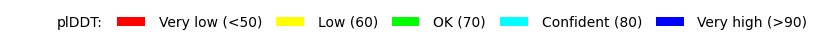

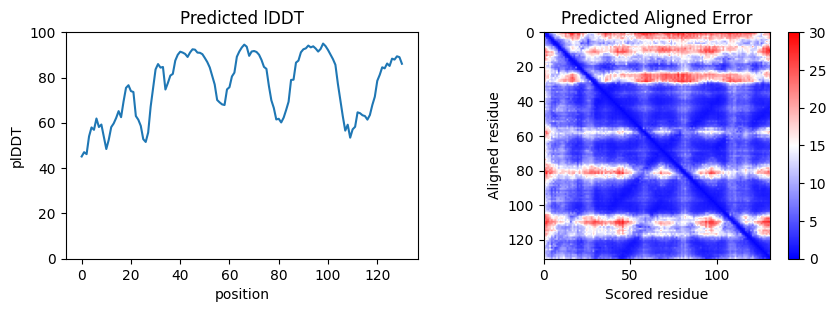

In [8]:
#@title Display 3D structure {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 5 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"{base_path}/output/{name_}/out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()